In [1]:
# General Imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import geopandas
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

import warnings
import random
import time

import skimage
from skimage.transform import rescale
import cv2

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [3]:
# local imports
from dataloader_v5 import Dataset

In [4]:
# define paths
spot6_mosaic = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'
spot6_path = "/home/simon/CDE_UBS/thesis/data_collection/spot6/"
sen2_path = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"
closest_dates_filepath = "/home/simon/CDE_UBS/thesis/data_loader/data/closest_dates.pkl"

# get dataset object
dataset = Dataset(spot6_mosaic,sen2_path,spot6_path,closest_dates_filepath,window_size=500,factor=(10/1.5))
loader = DataLoader(dataset,batch_size=1, shuffle=True, num_workers=1)
print("Loader Length: ",len(loader))

precalculated dataset file found, loading...

Dataset Object successfully instanciated!
Loader Length:  68150


# Test Interpolation and Loss

In [5]:
def interpolate(img):
    #img = rescale(img,6.6666666666666)
    img = cv2.resize(img, (500,500))
    return(img)

# https://arxiv.org/abs/1603.08155
# https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html

"""
Implement the following as losses
"""
# implement lpips, https://github.com/richzhang/PerceptualSimilarity
# MSE pixel-wise
# PSNR - peak signal to noise

def downsample(img):
    img = cv2.resize(img, (75,75))
    return(img)
    
    
def ssim_calc(a,b):
    ssim_const = ssim(a, b,data_range=b.max() - b.min(),multichannel=True)
    return(ssim_const)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


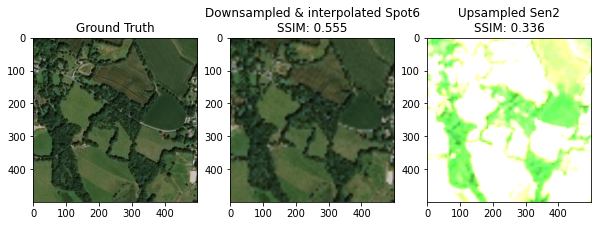

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


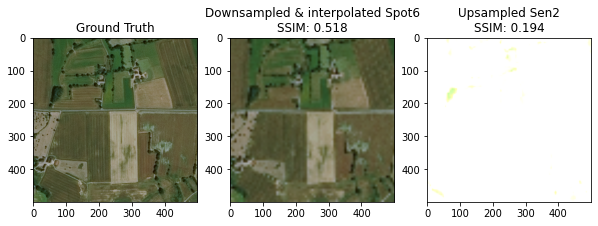

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


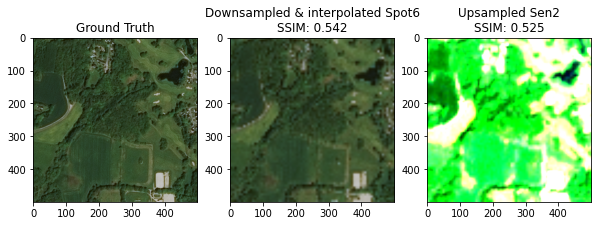

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


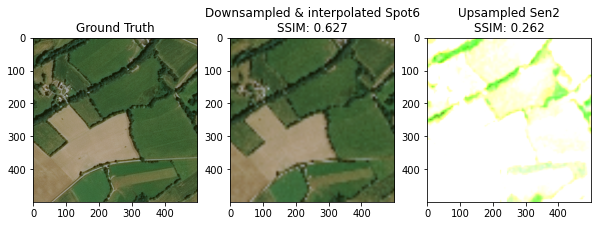

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


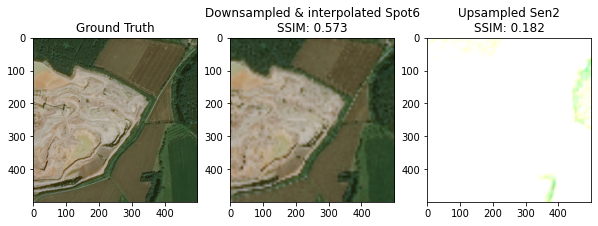

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


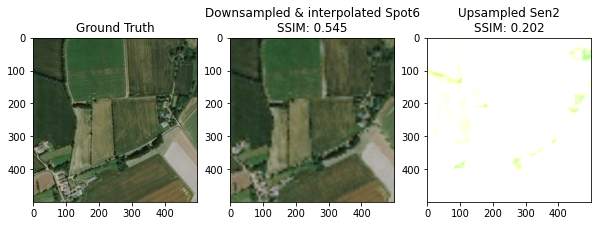

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


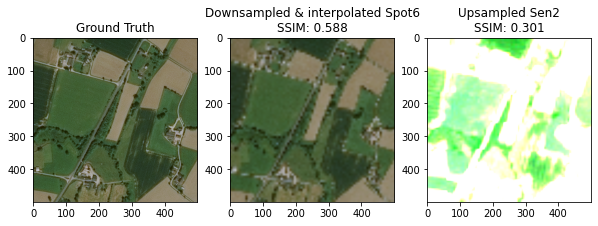

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


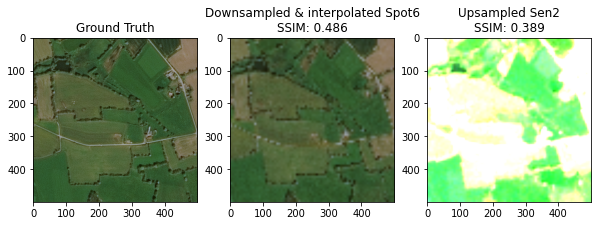

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


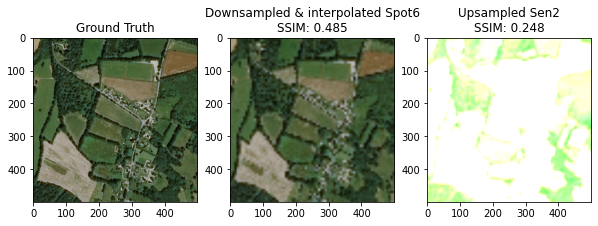

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


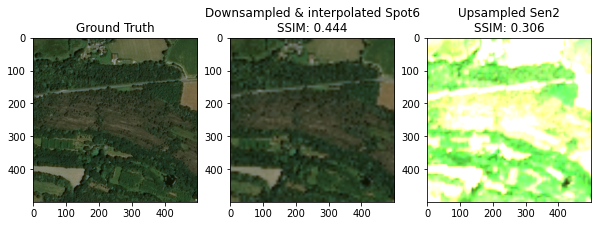

In [12]:
for i in range(0,10):
    a,b = dataset.__getitem__(random.randint(0,len(dataset)))
    a = np.transpose(a,(1,2,0))
    b = np.transpose(b,(1,2,0))
    
    loss_upsampled_sen2 = round(ssim_calc(a,interpolate(b)),3)
    loss_upsampled_spot6 = round(ssim_calc(a,interpolate(downsample(a))),3)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,5))
    #fig.suptitle("Similarity Test")
    ax1.imshow(a)
    ax1.set_title("Ground Truth")
    ax2.imshow(interpolate(downsample(a)))
    ax2.set_title("Downsampled & interpolated Spot6\nSSIM: "+str(loss_upsampled_spot6))
    ax3.imshow(interpolate(b))
    ax3.set_title("Upsampled Sen2\nSSIM: "+str(loss_upsampled_sen2))
    plt.show()